Import data

In [100]:
import numpy as np
import pandas as pd
# Import data from csv
data = pd.read_csv('App/Daten/data_new/less_wide.csv')

In [101]:
data.columns

Index(['BETRIEBSTAG', 'AN_diff', 'weekday', 'ab_hour', 'ab_minute', 'feiertag',
       'Temperatur', 'Niederschlag', 'Luftfeuchtigkeit', 'Wind',
       'haltestelle_ab_Basel SBB', 'haltestelle_ab_Bern',
       'haltestelle_ab_Lugano', 'haltestelle_ab_Luzern',
       'haltestelle_ab_Olten', 'haltestelle_ab_St. Gallen',
       'haltestelle_ab_Zürich HB', 'haltestelle_an_Basel SBB',
       'haltestelle_an_Bern', 'haltestelle_an_Lugano', 'haltestelle_an_Luzern',
       'haltestelle_an_Olten', 'haltestelle_an_St. Gallen',
       'haltestelle_an_Zürich HB', 'Linien_typ_EC', 'Linien_typ_IC',
       'Linien_typ_ICE', 'Linien_typ_IR', 'Einschr_type_Aufgehoben:',
       'Einschr_type_Einschraenkung', 'Einschr_type_Endmeldung:',
       'Einschr_type_Keine', 'Einschr_type_Unterbruch'],
      dtype='object')

In [102]:
betriebstage = data['BETRIEBSTAG']
data.drop('BETRIEBSTAG', axis=1, inplace=True)

In [103]:
data.head()

,AN_diff,weekday,ab_hour,ab_minute,feiertag,Temperatur,Niederschlag,Luftfeuchtigkeit,Wind,haltestelle_ab_Basel SBB,...,haltestelle_an_Zürich HB,Linien_typ_EC,Linien_typ_IC,Linien_typ_ICE,Linien_typ_IR,Einschr_type_Aufgehoben:,Einschr_type_Einschraenkung,Einschr_type_Endmeldung:,Einschr_type_Keine,Einschr_type_Unterbruch
0,118.650000,5,1,47,0,11.0,8.0,84.6,7.5,0,...,1,0,1,0,0,0,0,0,1,0
1,118.650000,5,1,6,0,1.2,4.8,75.3,6.8,0,...,1,0,1,0,0,0,0,0,1,0
2,118.200000,5,17,29,0,8.0,9.9,86.9,5.1,0,...,1,1,0,0,0,0,0,0,1,0
3,117.116667,1,11,2,0,-0.3,7.0,78.2,3.6,1,...,0,1,0,0,0,0,0,0,1,0
4,116.750000,4,20,59,0,20.0,0.0,86.6,3.3,0,...,1,0,1,0,0,0,0,0,1,0


In [104]:
# Defne X and y
X = data.drop('AN_diff', axis=1)
y = data['AN_diff']

In [105]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4153)

models = [
    # ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor', RandomForestRegressor(random_state=4153)),
    ('XGBRegressor', XGBRegressor(random_state=4153))
]

# Initialize list for base estimators of VotingRegressor
estimators = {}

# Initialize empty dataframe for results
all_results_voting = pd.DataFrame()

for name, model in models:
    model.fit(X_train, y_train)

    # Add the model to the estimators list
    estimators[name] = model

    # Predict y
    y_pred = model.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Save results in a dictionary
    result = {'R2': r2, 'RMSE': rmse, 'MAPE': mape, 'modelname': name}

    # Add to results dataframe
    all_results_voting = pd.concat([all_results_voting, pd.DataFrame([result])], ignore_index=True)    

# Voting Regressor
voting_regressor = VotingRegressor(list(estimators.items()))
voting_regressor.fit(X_train, y_train)

# Add model to estimators list
estimators['VotingRegressor'] = voting_regressor

# Predict y
y_pred = voting_regressor.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Save results in a dictionary
result = {'R2': r2, 'RMSE': rmse, 'MAPE': mape, 'modelname': 'VotingRegressor'}

# Add to results dataframe
all_results_voting = pd.concat([all_results_voting, pd.DataFrame([result])], ignore_index=True)    


In [106]:
all_results_voting.head()

,R2,RMSE,MAPE,modelname
0,0.056279,4.385759,3.260737e+13,LinearRegression
1,0.208278,4.017068,2.763888e+13,XGBRegressor
2,0.167322,4.119662,2.961701e+13,VotingRegressor


R2: 0.21
RMSE: 4.02
MAPE: 27638880833113.27


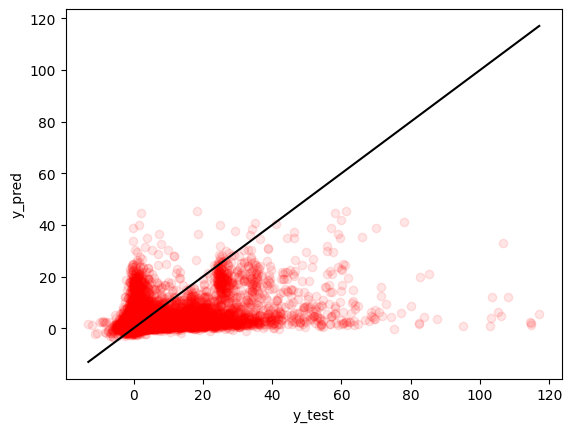

In [107]:
import matplotlib.pyplot as plt

# Identify the model with best RMSE
best_model_info = all_results_voting.loc[all_results_voting['RMSE'].idxmin()]

best_model_name = best_model_info['modelname']
best_model = estimators[best_model_name]

# Predict y
y_pred = best_model.predict(X_test)

# Calculate R2, RMSE and MAE
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R2: {r2:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}')

# Plot y_test and y_pred
plt.scatter(y_test, y_pred, alpha=0.1, color='red')
plt.xlabel('y_test')
plt.ylabel('y_pred')
# Calculate y_min and y_max
y_min = min(y_test.min(), y_pred.min())
y_max = max(y_test.max(), y_pred.max())
# Add line with x=y with y_min and y_max
plt.plot([y_min, y_max], [y_min, y_max], color='black')
plt.show()

In [109]:
import pickle
# save model to file
pickle.dump(best_model, open("App/Modell/model_improv.pkl", "wb"))

In [ ]:
data.shape

(423227, 32)

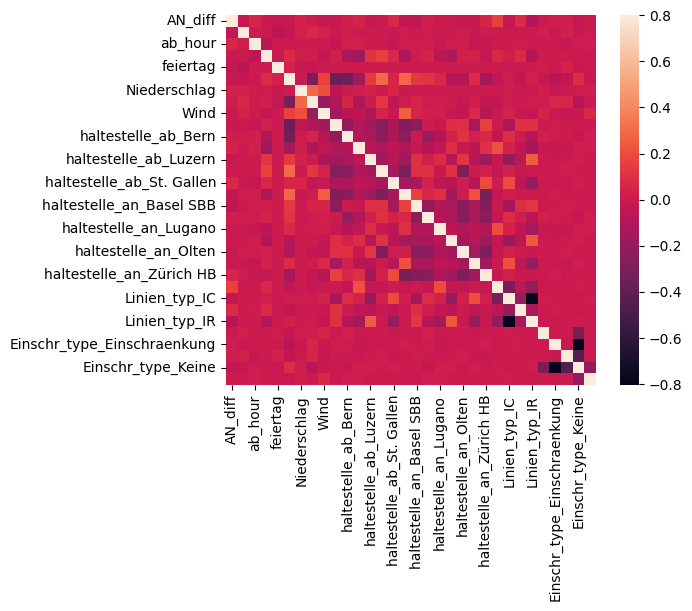

In [ ]:
corrmat = data.corr()

import seaborn as sns
sns.heatmap( corrmat , vmax = .8, square = True)
plt.show()

In [ ]:
# from App.helper.plot_importance import plot_variable_importance
# plot_variable_importance(estimators, X_train)

In [ ]:
# Assuming your dataframe is called df and your target column is called 'target'
correlations = data.corr()['AN_diff'].sort_values()

# We are interested in the absolute value of the correlations
correlations = correlations.apply(np.abs)

# Let's select the top 10 features that are most correlated with the target
top_features = correlations.nlargest(10).index

# Update your X to include only those top features
data[top_features]

,AN_diff,Linien_typ_EC,Linien_typ_IR,Linien_typ_ICE,haltestelle_ab_St. Gallen,ab_hour,haltestelle_an_Zürich HB,haltestelle_an_Basel SBB,haltestelle_ab_Lugano,haltestelle_ab_Zürich HB
0,118.650000,0,0,0,0,1,1,0,0,0
1,118.650000,0,0,0,0,1,1,0,0,0
2,118.200000,1,0,0,1,17,1,0,0,0
3,117.116667,1,0,0,0,11,0,0,0,0
4,116.750000,0,0,0,0,20,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
423222,-14.266667,1,0,0,0,7,1,0,0,0
423223,-14.866667,1,0,0,0,20,0,0,0,0
423224,-15.050000,1,0,0,0,17,0,0,0,0
423225,-15.266667,1,0,0,0,6,0,0,0,0


In [ ]:
from sklearn.decomposition import PCA

# Let's keep the top 10 principal components
pca = PCA(n_components=10)

# Fit and transform the features
X_pca = pca.fit_transform(X)

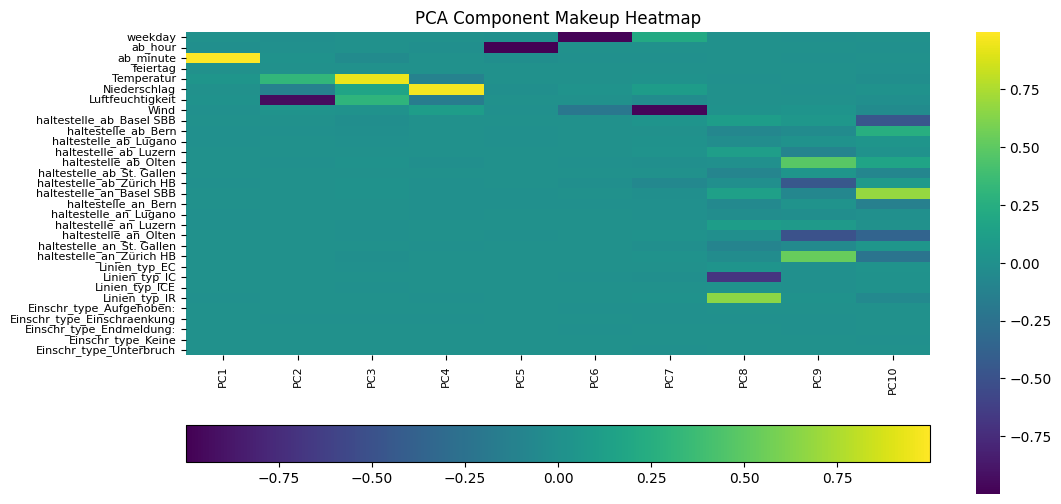

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming pca is your fitted PCA object and X_train are your original features
plt.figure(figsize=(12,6))

# Transpose the PCA components
components = np.transpose(pca.components_)

# Assign the seaborn heatmap to a variable
ax = sns.heatmap(components, cmap='viridis')

plt.yticks([i+0.5 for i in range(len(X_train.columns))], 
           X_train.columns, rotation=0, fontsize=8)
plt.xticks([i+0.5 for i in range(len(pca.components_))], 
           [f"PC{i+1}" for i in range(len(pca.components_))], rotation=90, fontsize=8)

# Pass the mappable object (heatmap) to the colorbar
plt.colorbar(ax.get_children()[0], orientation='horizontal')
plt.title('PCA Component Makeup Heatmap')
plt.show()
